# Introduction to Recurrent Neural Networks

The final neural network architecture we will cover is the recurrent neural network.

## What we will accomplish

In this notebook we will:
- Discuss the kinds of problems recurrent nets are designed for,
- Give an overview of basic RNN architectures,
- Build a RNN to predict IMDB review sentiment.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

### Single Hidden Layer RNN

Recurrent neural networks (RNN) were built to deal with sequential data. Some examples of sequential data include:
- Time series,
- Natural language,
- Music

Consider sequential data of the form $(x_t, y_t)$, with $x_t \in \mathbb{R}^p$ and $y_t \in \mathbb{R}^m$.

A Single Hidden Layer RNN has the following form.  We will call the single hidden layer the "state", and give it dimension $d$.  Let $\sigma_1$ and $\sigma_2$ be differentiable activation functions (often a single variable function applied to each coordinate).

$$
\begin{cases}
h_t = \sigma_1 (W_{hx} x_t + W_{hh} h_{t-1} + b_h)\\
y_t = \sigma_2 (W_{yh} h_t + b_y)
\end{cases}
$$

where the learnable parameters of the model are

* $h_{-1} \in \mathbb{R}^d$
* $W_{hx}$ is a $d \times p$ matrix 
* $W_{hh}$ is a $d \times d$ matrix
* $b_h$ is a vector in $\mathbb{R}^d$
* $W_{yh}$ is a $m \times d$ matrix
* $b_y$ is a vector in $\mathbb{R}^m$

The most common choice for $\sigma_1$ is $\tanh$ and the most common choice for $\sigma_2$ is the identity function.

RNNs can be more complicated than this, but we will stick with this example for the purposes of this introduction to the concept.

### Custom implementation

The following custom implementation of an RNN class might help to understand what is going on:

In [2]:
class RNN:
  def __init__(self, p,d,m, sigma_1 = np.tanh, sigma_2 = None, print_h = False):
    self.h = np.zeros((d,1))
    self.W_hh = np.random.randn(d,d)
    self.W_hx = np.random.randn(d,p)
    self.W_yh = np.random.randn(m,d)
    self.b_h = np.random.randn(d,1)
    self.b_y = np.random.randn(m,1)
    self.sigma_1 = sigma_1
    self.sigma_2 = sigma_2
    self.print_h = print_h
  def predict(self, x):
    # update the hidden state
    x = x.reshape(-1,1)
    if self.print_h:
      print(f"old h = {self.h}")
    self.h = np.dot(self.W_hh, self.h) + np.dot(self.W_hx, x) + self.b_h
    if self.sigma_1:
      self.h = self.sigma_1(self.h)
    if self.print_h:
      print(f"new h = {self.h}")
    # compute the output vector
    y = np.dot(self.W_yh, self.h) + self.b_y
    if self.sigma_2:
      y = self.sigma_2(y)
    return y

In [3]:
np.dot(np.random.randn(3,2), np.zeros((2,1)))

array([[0.],
       [0.],
       [0.]])

In [4]:
# Example with input dimension 2, hidden state of dimension 3, output of dimension 1.
rnn = RNN(2,3,1, print_h=True)

In [5]:
# printing the attributes
import pprint
pprint.pprint(rnn.__dict__)

{'W_hh': array([[-0.63282707,  0.22436773,  0.45448301],
       [ 0.58196391,  1.12734165,  1.18817211],
       [-0.42256342,  0.29288104, -0.24772554]]),
 'W_hx': array([[ 0.84041325,  1.48593396],
       [ 1.2816766 , -0.60012103],
       [-1.52043728, -0.75704232]]),
 'W_yh': array([[-0.41013604, -1.04794364,  1.6664488 ]]),
 'b_h': array([[-0.22004492],
       [-0.58918001],
       [-0.25004377]]),
 'b_y': array([[0.45533289]]),
 'h': array([[0.],
       [0.],
       [0.]]),
 'print_h': True,
 'sigma_1': <ufunc 'tanh'>,
 'sigma_2': None}


In [6]:
# run this a few times and discuss how the outputs are being computed.
rnn.predict(np.array([0.3, 0.1]))

old h = [[0.]
 [0.]
 [0.]]
new h = [[ 0.17873191]
 [-0.25867618]
 [-0.65378398]]


array([[-0.43639099]])

The only thing which gets updated when we predict is the state vector $h$.  All of the other attributes are parameters which we would update during training but not when making predictions.

In [7]:
pprint.pprint(rnn.__dict__)

{'W_hh': array([[-0.63282707,  0.22436773,  0.45448301],
       [ 0.58196391,  1.12734165,  1.18817211],
       [-0.42256342,  0.29288104, -0.24772554]]),
 'W_hx': array([[ 0.84041325,  1.48593396],
       [ 1.2816766 , -0.60012103],
       [-1.52043728, -0.75704232]]),
 'W_yh': array([[-0.41013604, -1.04794364,  1.6664488 ]]),
 'b_h': array([[-0.22004492],
       [-0.58918001],
       [-0.25004377]]),
 'b_y': array([[0.45533289]]),
 'h': array([[ 0.17873191],
       [-0.25867618],
       [-0.65378398]]),
 'print_h': True,
 'sigma_1': <ufunc 'tanh'>,
 'sigma_2': None}


### Double Exponential Smoothing is an instance of RNN.

Just as linear regression is the most basic instance of a FFNN, exponential smoothing is the most basic instance of an RNN.

Recall the set up of double exponential smoothing:

We iteratively update a hidden state consisting of level $s_t$ and slope $b_t$ for a time series $y_t$.

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_{n}& \text{for} & t > n \end{array}\right\rbrace, 
$$

where 

$$
s_{t} = \alpha y_t + (1-\alpha) (s_{t-1} + b_{t-1}), \ s_1 = y_1,
$$

$$
b_{t} = \beta (s_t - s_{t-1}) + (1-\beta) b_{t-1}, \ b_1 = y_2 - y_1 \text{ and}
$$

This can be re-written (with some algebra) using our notation above as

$$
h_t = \begin{bmatrix} \alpha \\ \alpha \beta \end{bmatrix} y_t + \begin{bmatrix} 1-\alpha & 1-\alpha \\ -\alpha\beta & 1-\alpha\beta \end{bmatrix} \begin{bmatrix} s_{t-1} \\ b_{t-1}\end{bmatrix}\\
\hat{y}_t = \begin{bmatrix} 1 & 1\end{bmatrix} \begin{bmatrix} s_{t-1} \\ b_{t-1}\end{bmatrix}
$$

So double exponential smoothing is in fact a special case of `RNN(1,2,1)`.

Let's implement it as a subclass!

In [8]:
class DoubleExpSmooth(RNN):
    def __init__(self, alpha, beta, print_h = False):
        super().__init__(1,2,1, None),
        self.W_hh = np.array([[1-alpha, 1-alpha],[-alpha*beta, 1-alpha*beta]])
        self.W_hx = np.array([[alpha],[beta*alpha]])
        self.W_yh = np.array([[1, 1]])
        self.b_h = np.array([[0],[0]])
        self.b_y = np.array([[0]])
        self.print_h = print_h

In [9]:
# Let's see how it handles predicting a noisy linear sequence

des = DoubleExpSmooth(0.7,0.8, print_h = True)
ys = 0.8*np.random.randn(10) + 2* np.arange(10) + 1
preds = list()

for i in range(10):
    pred = des.predict(ys[i])[0,0]
    print(f"\ninput = {ys[i]:.4f}, pred = {pred:4f} \n")
    preds.append(pred)

old h = [[0.]
 [0.]]
new h = [[0.26442148]
 [0.21153719]]

input = 0.3777, pred = 0.475959 

old h = [[0.26442148]
 [0.21153719]]
new h = [[1.96037273]
 [1.39906844]]

input = 2.5966, pred = 3.359441 

old h = [[1.96037273]
 [1.39906844]]
new h = [[4.00348911]
 [1.91430679]]

input = 4.2795, pred = 5.917796 

old h = [[4.00348911]
 [1.91430679]]
new h = [[7.02600509]
 [2.80087414]]

input = 7.5010, pred = 9.826879 

old h = [[7.02600509]
 [2.80087414]]
new h = [[9.64786339]
 [2.65766147]]

input = 9.5711, pred = 12.305525 

old h = [[9.64786339]
 [2.65766147]]
new h = [[12.45078523]
 [ 2.77386977]]

input = 12.5130, pred = 15.224655 

old h = [[12.45078523]
 [ 2.77386977]]
new h = [[13.56134034]
 [ 1.44321804]]

input = 12.8485, pred = 15.004558 

old h = [[13.56134034]
 [ 1.44321804]]
new h = [[14.73814521]
 [ 1.2300875 ]]

input = 14.6240, pred = 15.968233 

old h = [[14.73814521]
 [ 1.2300875 ]]
new h = [[17.35889668]
 [ 2.34261868]]

input = 17.9549, pred = 19.701515 

old h = [[17

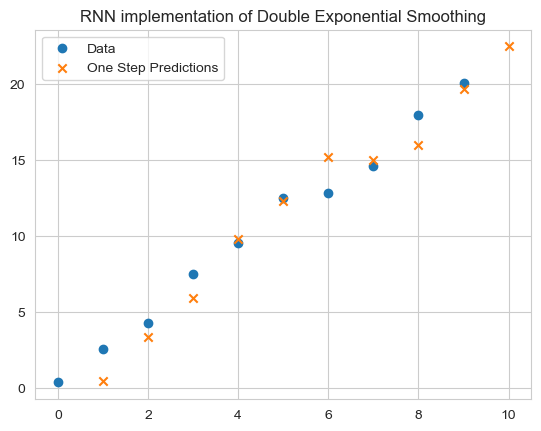

In [10]:
plt.title("RNN implementation of Double Exponential Smoothing")
plt.scatter(range(10),ys, label = 'Data')
plt.scatter(range(1,11),preds, label = 'One Step Predictions', marker='x')
plt.legend()
plt.show()


### Training an RNN

Training an RNN involves [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time).  We "unroll" the RNN for $k$ time steps to treat it like a feed forward neural network with $k$ layers, but where the parameters of each layer are shared.  We would then implement gradient descent on the loss function as usual.  Note that the resulting trained model will still have an "infinite memory" even though we only accounted for $k$ time steps in the loss minimization process.

A major technical issue when training RNNs is the [vanishing/exploding gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem):  the recurrent nature of the network can lead to exponential growth/decay of the model parameters during training.

## Example: IMDB sentiment analysis

As an illustrative example we will use `keras` to build a sentiment classifier using IMDB movie reviews. Let's first load this data set.

In [11]:
## The data is stored in here
from keras.datasets import imdb

In [12]:
## This will determine the number of vocab words in our
## dictionary
max_features = 10000

## num_words tells keras to return the reviews so they contain only
## the num_words most used words across all the reviews
(X_train, y_train), (X_test,y_test) = imdb.load_data(num_words=max_features)


In [13]:
## Let's look at the first training observation
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


The data is stored as a list of indices, each of which is representative of a word. Let's see what this particular review looks like, once we have translated it from indices to words. Do not focus on the following code for now, as it is not important for building the neural network.

In [14]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

## The first training review, where words outside the top 1000 are replaced with
## ? marks
print(" ".join([reverse_word_index.get(i-3, '?') for i in X_train[0]]))
print()
print("sentiment value =", y_train[0])

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

The review above had a $y$ value of $1$, meaning that it has positive sentiment. A value of $0$ indicates a negative sentiment.



### Making the Network

This network will introduce two new layer types `Embedding` and `SimpleRNN`. 

The [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer is preprocessing step which is specific to NLP tasks. You can think of it as a dense layer which takes your one-hot encoded vocabulary to a latent space of specified dimension.  It is implemented as its own custom class instead of just using a dense layer for a couple of reasons:  

* Each input of the mode will use only a small fraction of the vocabulary, so it is inefficient to actually use one-hot encoding.
* Creating these kinds of "word embeddings" is common enough, and has accumulated enough task specific techniques, that it makes sense to have a dedicated class.

The [`SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/) layer is the akin to the RNN architecture we described above, but with $y_t = h_t$, i.e.

* $\sigma_2$ is the identity function
* $W_yh$ is the identity matrix
* $b_y = 0$

In [15]:
## Import all the keras stuff we'll need
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor
from tensorflow import ragged
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics


In [16]:
# Reloading the data
max_features = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Padding the sequences so they all have the same length
maxlen = 500  # You can adjust this value to fit your data better
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Split into training and validation
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                              test_size=0.2,
                                                              shuffle=True,
                                                              stratify=y_train,
                                                              random_state=440)

# Converting the target labels to tensor format
y_train = convert_to_tensor(y_train_train)
y_val = convert_to_tensor(y_val)
y_test = convert_to_tensor(y_test)

In [17]:
model = models.Sequential([
    layers.InputLayer((max_features,)),
    layers.Embedding(max_features, 32), 
    layers.SimpleRNN(10),
    layers.Dense(1, activation='sigmoid')
    ])

* The Embedding layer has $10000 \times 32 = 320000$ parameters 
* The SimpleRNN layer has:
    * $W_{hx}$ gives us $10 \times 32 = 320$ parameters
    * $W_{hh}$ gives us $10 \times 10 = 100$ parameters
    * $b_h$ gives us $10$ parameters
    * Total of $430$ parameters
* The dense layer has $10 + 1 = 11$ parameters ($10$ weights and $1$ bias).

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10000, 32)      │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,441 (1.22 MB)

 Trainable params: 320,441 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
for weight in model.get_weights():
    print(weight.shape)

(10000, 32)
(32, 10)
(10, 10)
(10,)
(10, 1)
(1,)


In [20]:
model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [21]:
epochs = 8

history = model.fit(X_train_train, y_train_train,
                    epochs = epochs,
                    batch_size=128,
                    validation_data=(X_val,y_val))

Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5644 - loss: 0.6796 - val_accuracy: 0.7784 - val_loss: 0.5581
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7960 - loss: 0.5150 - val_accuracy: 0.7996 - val_loss: 0.4674
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8458 - loss: 0.3933 - val_accuracy: 0.8104 - val_loss: 0.4311
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8743 - loss: 0.3270 - val_accuracy: 0.8500 - val_loss: 0.3711
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8917 - loss: 0.2861 - val_accuracy: 0.8358 - val_loss: 0.3790
Epoch 6/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9127 - loss: 0.2416 - val_accuracy: 0.8568 - val_loss: 0.3661
Epoch 7/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9220 - loss: 0.2183 - val_accuracy: 0.7534 - val_loss: 0.6389
Epoch 8/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9239 - loss: 0.2066 - val_accurac

In [22]:
history_dict = history.history

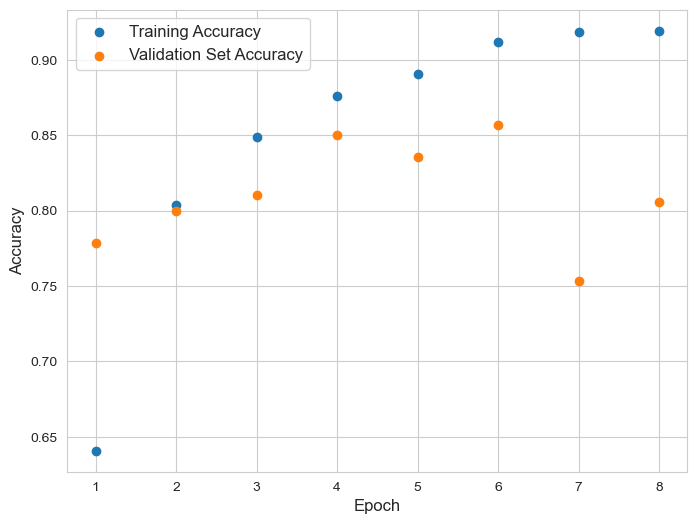

In [23]:
## Plotting the training and validation accuracy
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

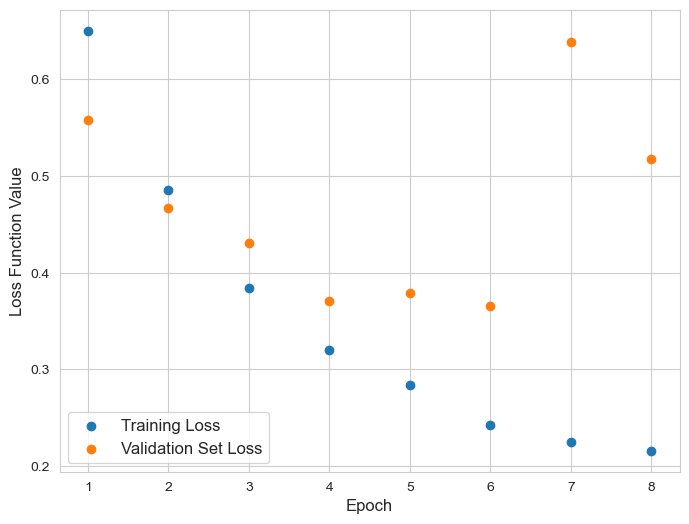

In [24]:
## Plotting the training and validation loss
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

# Train and save final model.

Four epochs seems like enough.  Let's retrain on the training + validation set, see the test set accuracy, and save the model checkpoint.

In [25]:
final_model = models.Sequential([
    layers.Embedding(max_features, 32), 
    layers.SimpleRNN(10, return_sequences=False),
    layers.Dense(1, activation='sigmoid')
    ])

final_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

epochs = 4

final_model.fit(X_train_train, y_train_train,
                epochs = epochs,
                batch_size=128)

Epoch 1/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5447 - loss: 0.6838
Epoch 2/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7708 - loss: 0.5256
Epoch 3/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8289 - loss: 0.4155
Epoch 4/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8651 - loss: 0.3372


In [26]:
preds = final_model.predict(X_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [27]:
preds.reshape(-1).round()

array([0., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds.reshape(-1).round())

0.82228

In [29]:
final_model.save('lecture_12_assets/imdb_model.keras')

## Next steps

`SimpleRNN` is actually a seldom used RNN layer type because there are more complicated `keras` layers that tend to outperform `SimpleRNN`.  In particular, the most commonly used RNN layer used in practice are [Long Short Term Memory (`LSTM`)](https://en.wikipedia.org/wiki/Long_short-term_memory) layers, which partially address the vanishing gradient problem by allowing the RNN to "forget" irrelevant pieces of information.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)